In [23]:
import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [85]:
class ParamsEncoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.lin2 = nn.Linear(hidden_dim, input_dim, bias=True)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU(inplace=True)
        self.lin1.weight = nn.init.xavier_normal_(self.lin1.weight)
        self.lin2.weight = nn.init.xavier_normal_(self.lin2.weight)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.relu(self.lin2(self.tanh(self.lin1(X))))
    
    def get_embedding(self, X: torch.Tensor) -> torch.Tensor:
        return self.tanh(self.lin1(X))

In [90]:
class ParamsDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.df = df

    def __getitem__(self, index: int) -> np.ndarray:
        params = self.df.iloc[index].values[:6]
        return params
    
    def __len__(self) -> int:
        return self.df.shape[0]

In [91]:
param_enc = ParamsEncoder(input_dim=6, hidden_dim=3).float()
loss_func = nn.MSELoss()
optim = Adam(list(param_enc.parameters()), lr=1e-7)
dataset = ParamsDataset(pd.read_csv("../data/processed/train.csv"))
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [92]:
epochs = 300
loss_history = []
metric_history = []

In [93]:
for epoch in range(epochs):
    mean_loss = 0.0
    n_iters = 0

    param_enc.train()
    for i, X in enumerate(dataloader):
        X = X.float()
        y = X.clone()
        output = param_enc(X)
        loss = loss_func(y, output)
        mean_loss += loss.item()
        n_iters += 1
    
    mean_loss = mean_loss / n_iters
    loss_history.append(mean_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, loss: {loss_history[-1]}")

Epoch: 100, loss: 231.23613739013672
Epoch: 200, loss: 246.9503288269043
Epoch: 300, loss: 227.56005477905273


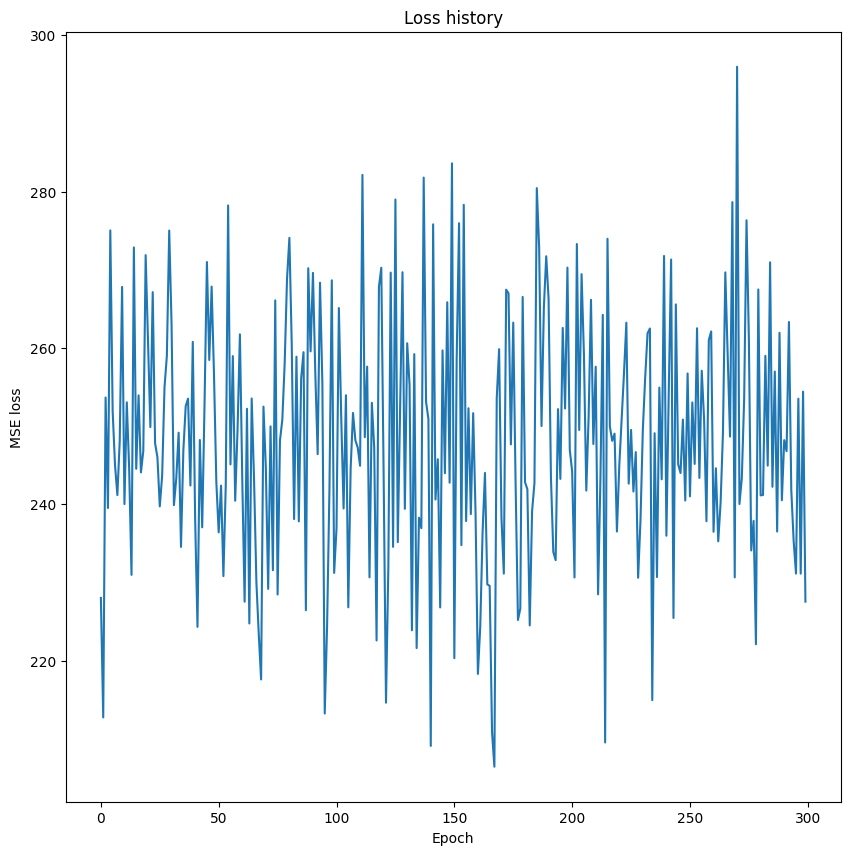

In [94]:
plt.figure(1, figsize=(10, 10))
plt.title("Loss history")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.plot(loss_history)
plt.show()